# Detecting Extreme Precipitation Events

In [82]:
import xarray as xr
import numpy as np
# Multi-threading
from dask.distributed import Client, LocalCluster
# Plotting
import matplotlib.pyplot as plt
# Cosmetic options
from rich import print
%load_ext rich

BASE_PATH = '/scratch/midway3/nnn/'

The rich extension is already loaded. To reload it, use:
  %reload_ext rich


## Start a Dask Cluster

In [ ]:
# Start cluster (must be single threaded for type safety)
cluster = LocalCluster(n_workers=5)
client = Client(cluster)
client

## Load Data

In [ ]:
open_kwargs = dict(
    chunks={'time':-1, 'lat':10, 'lon':10},
    parallel=True,
    # engine='h5netcdf',
)
ds_cp = xr.open_mfdataset(f'{BASE_PATH}*_cp.nc', **open_kwargs)
ds_lsp = xr.open_mfdataset(f'{BASE_PATH}*_lsp.nc', **open_kwargs)
ds_cape = xr.open_mfdataset(f'{BASE_PATH}*_cape.nc', **open_kwargs)

### Combine datasets and coarsen

In [ ]:
ds = ds_cp.merge(ds_cape).merge(ds_lsp)
ds = (
    ds
    .assign(tp=lambda x: x.cp+x.lsp)
    # may remove one lat/lon coordinate if boundaries aren't divisible by 2
    .coarsen(latitude=2, longitude=2, boundary='trim').sum()
)
ds

### Doing the same for local data

In [105]:
open_kwargs = dict(
    chunks={'time':-1, 'lat':10, 'lon':10},
    parallel=True,
    # engine='h5netcdf',
)
ds = (
    xr.open_mfdataset(f'../../local_data/*.nc', **open_kwargs)
    .coarsen(latitude=2, longitude=2, boundary='trim').sum()
    .resample(time='1D').mean()
    .rename({'tp': 'daily_tp'})
)
ds

<xarray.Dataset>
Dimensions:    (longitude: 20, latitude: 20, time: 2922)
Coordinates:
  * longitude  (longitude) float32 50.12 50.62 51.12 51.62 ... 58.62 59.12 59.62
  * latitude   (latitude) float32 29.88 29.38 28.88 28.38 ... 21.38 20.88 20.38
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2018-12-31
Data variables:
    daily_tp   (time, latitude, longitude) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-22 02:05:19 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Detect events

1. Coarsen ERA5 `tp` to a given grid size, summing all grid points in a region. 
2. Remove long-term linear trend.
3. Remove monthly mean data $\to$ $tp_{adj} = tp - \bar{tp}_{month}$
4. Run a `N`-day moving sum of precipitation. For each time slice calculate the normalized anomaly from the mean and whether the time slice is in the 99.9th percentile for that region. We can then set a threshold for how high above the mean an event needs to be to qualify as an extreme event.


<xarray.DataArray 'daily_tp' (month: 12, latitude: 20, longitude: 20)>
dask.array<stack, shape=(12, 20, 20), dtype=float32, chunksize=(1, 20, 20), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 50.12 50.62 51.12 51.62 ... 58.62 59.12 59.62
  * latitude   (latitude) float32 29.88 29.38 28.88 28.38 ... 21.38 20.88 20.38
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:      m
    long_name:  Total precipitation

<xarray.DataArray (time: 2922, latitude: 20, longitude: 20)>
dask.array<add, shape=(2922, 20, 20), dtype=float64, chunksize=(2922, 20, 20), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2018-12-31
  * latitude   (latitude) float32 29.88 29.38 28.88 28.38 ... 21.38 20.88 20.38
  * longitude  (longitude) float32 50.12 50.62 51.12 51.62 ... 58.62 59.12 59.62

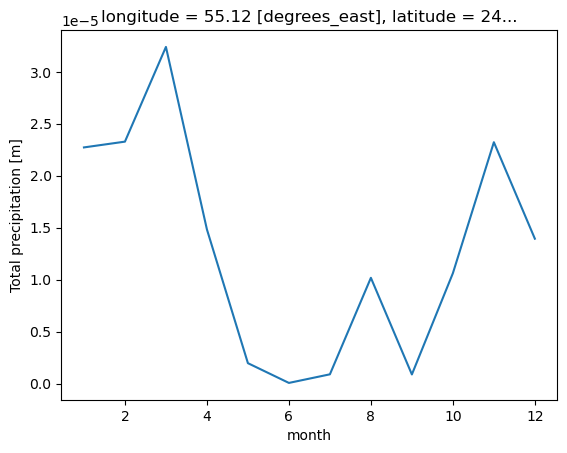

In [107]:
# To obtain monthly means, we need to sum by day of year
monthly_means = (
    ds.daily_tp
    .groupby('time.month').mean() # get means across months
)
monthly_means.isel(latitude=10, longitude=10).plot()
# Get long term trends
linear_fit = (
    ds.daily_tp
    .polyfit(dim='time', deg=1)
)
fit_values = xr.polyval(ds['time'], linear_fit.polyfit_coefficients)
print(monthly_means)
print(fit_values)

### Remove seasonal signal and long term trend

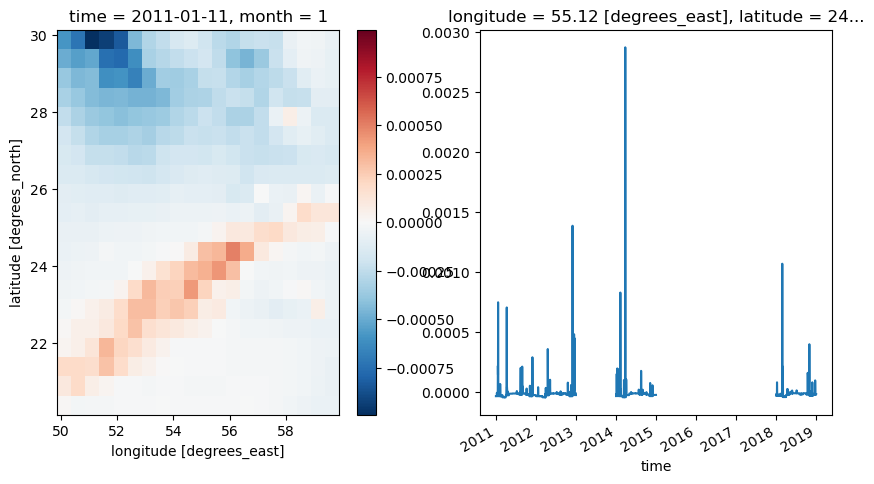

In [108]:
detrended_tp = ds.daily_tp.groupby('time.month') - monthly_means - fit_values

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
detrended_tp.isel(time=10).plot(ax=axs[0])
detrended_tp.isel(latitude=10, longitude=10).plot(ax=axs[1])
plt.show()

## Normalized anomaly from the mean and percentile

In [109]:
tp_percentiles = detrended_tp.chunk({'time':-1}).quantile([0.9, 0.99, 0.999], dim='time')
normalized_anomaly = (
    (detrended_tp - detrended_tp.mean('time')).groupby('time.month') / detrended_tp.groupby('time.month').std('time')
)
normalized_anomaly

<xarray.DataArray (time: 2922, latitude: 20, longitude: 20)>
dask.array<truediv, shape=(2922, 20, 20), dtype=float64, chunksize=(31, 20, 20), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 50.12 50.62 51.12 51.62 ... 58.62 59.12 59.62
  * latitude   (latitude) float32 29.88 29.38 28.88 28.38 ... 21.38 20.88 20.38
  * time       (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2018-12-31
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12

### Add everything back to dataset

In [112]:
ds_expanded = (
    ds.assign(
        tp_percentiles=tp_percentiles,
        normalized_daily_tp_anomaly=normalized_anomaly
    )
)
ds_expanded.to_netcdf(f'../../{BASE_PATH}/intermediate/edited_daily_tp.nc')
ds_expanded

<xarray.Dataset>
Dimensions:                      (longitude: 20, latitude: 20, time: 2922,
                                  quantile: 3)
Coordinates:
  * longitude                    (longitude) float32 50.12 50.62 ... 59.12 59.62
  * latitude                     (latitude) float32 29.88 29.38 ... 20.88 20.38
  * time                         (time) datetime64[ns] 2011-01-01 ... 2018-12-31
  * quantile                     (quantile) float64 0.9 0.99 0.999
    month                        (time) int64 1 1 1 1 1 1 ... 12 12 12 12 12 12
Data variables:
    daily_tp                     (time, latitude, longitude) float32 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
    tp_percentiles               (quantile, latitude, longitude) float64 dask.array<chunksize=(3, 20, 20), meta=np.ndarray>
    normalized_daily_tp_anomaly  (time, latitude, longitude) float64 dask.array<chunksize=(1, 20, 20), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-22 02:05:19 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Stop Dask cluster

In [ ]:
client.shutdown()